# reGrainable - <font color='orange'>Grain Shapes v2</font>

This notebook will import the CSV file generated by scikit-image regionprop and analysize the grains shapes.

Changes:


Miguel Moreno, NBI-UCPH, 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tkinter import Tcl
import sys
import os


from scipy.ndimage import gaussian_filter1d

from scipy.stats import pearsonr, linregress
from pathlib import Path

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LogLocator
%matplotlib inline 

import plots
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

In [2]:
resolution_mm = 10
# Constants
len_img = 12000  # Length of the image in pixels (adjust as needed).
step_size = 200  # Depth step in pixels for analysis (adjustable).
overlap = 2000  # Overlap size in pixels (adjustable).
px_to_cm = 1 / 2000  # 1px = 1/2000cm Conversion factor from pixels to centimeters.
interval_half = (
    resolution_mm / 10 / 2 / px_to_cm
)  # interval size: change first number to interval size in mm, 1000 pixel = 5mm Half the interval width for local averaging, in pixels.

In [3]:
def read_csv(path, bags):
    """
    Reads CSV files with grain size data and puts it in a dictionary of DataFrames.

    Parameters:
    - path (str or Path): Base path of CSV files.
    - bags (list of str): List of bag name strings.

    Returns:
    - df (dict): Dictionary containing DataFrames of data for each bag.
    """
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        # Define the path for the current bag using pathlib for robust path handling
        bag_path = base_path / bag
        # Find all CSV files in the directory, ensuring a consistent sorting mechanism
        files = sorted(bag_path.glob("*.csv"), key=lambda x: x.stem)
        print("# files:", len(files))

        # Initialize an empty DataFrame for aggregating data from all files for the current bag
        df_bag = pd.DataFrame()
        for i, file_path in enumerate(files):
            # Read CSV file
            new_df = pd.read_csv(file_path)
            # Assign 'crop_image' based on file order, similar to original function's intention
            new_df["crop_image"] = i
            # Concatenate the newly read DataFrame into the aggregated DataFrame
            df_bag = pd.concat([df_bag, new_df], ignore_index=True)

        # Assign the aggregated DataFrame to the corresponding bag in the output dictionary
        df[bag] = df_bag

    return df
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Function to read CSV files
def read_csv(path, bags):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / bag
        files = sorted(bag_path.glob("*.csv"), key=lambda x: x.stem)
        print("# files:", len(files))
        df_bag = pd.DataFrame()
        for i, file_path in enumerate(files):
            new_df = pd.read_csv(file_path)
            new_df["crop_image"] = i
            df_bag = pd.concat([df_bag, new_df], ignore_index=True)
        df[bag] = df_bag
    return df


# Function to calculate grain sizes over depth
def sizes_depth(df, list_bags):
    df_sizes = {}
    for bag in list_bags:
        print(bag)
        columns = [
            "crop_image",
            "depth[m]",
            "equivalent_diameter[px]",
            "grain_size[px]",
            "grain_size_err[px]",
            "centroid_x",
            "centroid_y",
            "orientation",
            "major_axis_length",
            "minor_axis_length",
            "perimeter",
        ]
        df_sizes[bag] = pd.DataFrame(columns=columns)

        bag_1, bag_2 = bag + "_1", bag + "_2"
        depth = [0]

        df_bag_2 = df.get(bag_2, df[bag_1])
        crop_images = np.unique(df[bag_1].crop_image)

        for i, crop_image in enumerate(crop_images):
            df_img1_i = df[bag_1][df[bag_1].crop_image == crop_image]
            df_img2_i = df_bag_2[df_bag_2.crop_image == crop_image]

            for ii in range(int(len_img / step_size)):
                x_img = step_size * ii + step_size / 2
                if i != 0 and x_img < overlap:
                    continue

                depth.append(depth[-1] + step_size * px_to_cm / 100)

                df_img1_interval = df_img1_i[
                    (df_img1_i.centroid_x >= x_img - interval_half)
                    & (df_img1_i.centroid_x < x_img + interval_half)
                ]
                df_img2_interval = df_img2_i[
                    (df_img2_i.centroid_x >= x_img - interval_half)
                    & (df_img2_i.centroid_x < x_img + interval_half)
                ]

                df_img_interval = pd.concat(
                    [df_img1_interval, df_img2_interval], ignore_index=True
                )

                new_size = np.mean(df_img_interval.area)
                new_diameter = np.mean(df_img_interval.equivalent_diameter)
                new_centroid_x = np.mean(df_img_interval.centroid_x)
                new_centroid_y = np.mean(df_img_interval.centroid_y)
                new_orientation = np.mean(df_img_interval.orientation)
                new_major_axis_length = np.mean(df_img_interval.major_axis_length)
                new_minor_axis_length = np.mean(df_img_interval.minor_axis_length)
                new_perimeter = np.mean(df_img_interval.perimeter)

                new_row = {
                    "crop_image": crop_image,
                    "depth[m]": depth[-1],
                    "equivalent_diameter[px]": new_diameter,
                    "grain_size[px]": new_size,
                    "grain_size_err[px]": 0,
                    "centroid_x": new_centroid_x,
                    "centroid_y": new_centroid_y,
                    "orientation": new_orientation,
                    "major_axis_length": new_major_axis_length,
                    "minor_axis_length": new_minor_axis_length,
                    "perimeter": new_perimeter,
                }
                df_sizes[bag] = pd.concat(
                    [df_sizes[bag], pd.DataFrame([new_row])], ignore_index=True
                )

    return df_sizes


# Path to the CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/csv/grain_properties/"
with open("../data/bag-list.txt", "r") as file:
    bag_list = [line.strip() for line in file if line.strip()]
df = read_csv(file_path, bag_list)

# Cut-off and binning parameters
cut_off = 100000
Nbins = 100
xmin = cut_off / 1e6
xmax = 20
binwidth = (xmax - xmin) / Nbins

sizes_mm = np.array([])
for bag in df.keys():
    df[bag] = df[bag][df[bag].area > cut_off]
    new_array = np.array(df[bag]["area"] / 1000000)
    sizes_mm = np.concatenate((sizes_mm, new_array))

# Calculate sizes over depth
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list1 = [line.strip() for line in file if line.strip()]

df_sizes = sizes_depth(df, bag_list1)

# Load slicing parameters for specific adjustments
slicing_param_path = (
    "/home/miguel/Documents/10_projects/reGrainable/data/csv/slicing_param.csv"
)
slicing_param = pd.read_csv(slicing_param_path)
slicing_param = slicing_param[slicing_param["name"] == "nmx3642c_1"]

# General depth adjustment for all bags except "nmx3642b"
for bag in df_sizes.keys():
    if bag == "nmx3642b":
        continue
    try:
        bag_number = int(bag[3:-1])
        bag_top = (bag_number - 1) * 0.55
        depth_new = df_sizes[bag]["depth[m]"] + bag_top
        df_sizes[bag]["depth[m]"] = depth_new
        df_sizes[bag] = df_sizes[bag].sort_values(by=["depth[m]"])
    except ValueError:
        print(f"Bag {bag} has wrong name, which has to be in format of 'nmx0000a'.")

# Specific adjustment for "nmx3642b"
if "nmx3642b" in df_sizes:
    bag = "nmx3642b"
    try:
        bag_number = int(bag[3:-1])
        bag_top = (bag_number - 1) * 0.55
        px_adjustment = (
            (slicing_param["px_right"].iloc[0] - slicing_param["px_left"].iloc[0])
            * px_to_cm
            / 100
        )
        depth_new = df_sizes[bag]["depth[m]"] + bag_top + px_adjustment
        df_sizes[bag]["depth[m]"] = depth_new
        df_sizes[bag] = df_sizes[bag].sort_values(by=["depth[m]"])
    except ValueError:
        print(f"Bag {bag} has wrong name, which has to be in format of 'nmx0000a'.")

# Save CSV files into the dynamically named folder
folder_name = f"resolution_{resolution_mm}mm-v2"
base_path = f"/home/miguel/Documents/10_projects/reGrainable/data/{folder_name}/"
Path(base_path).mkdir(parents=True, exist_ok=True)
for bag in df_sizes.keys():
    df_sizes[bag].to_csv(f"{base_path}{bag}.csv", index=False)


# Function to read and add aspect ratio to CSV files
def read_and_add_aspect_ratio(path, bags):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )
        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = f"/home/miguel/Documents/10_projects/reGrainable/data/{folder_name}/"
with open("../data/bag-list.txt", "r") as file:
    bag_list = [line.strip() for line in file if line.strip()]
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

nmx3642b_1
# files: 6
nmx3642b_2
# files: 6
nmx3642c_1
# files: 5
nmx3642c_2
# files: 5
nmx3643b_1
# files: 11
nmx3643b_2
# files: 11
nmx3644b_1
# files: 11
nmx3644b_2
# files: 11
nmx3645c_1
# files: 11
nmx3646b_1
# files: 11
nmx3646b_2
# files: 11
nmx3647b_1
# files: 11
nmx3647b_2
# files: 11
nmx3649c_1
# files: 11
nmx3649c_2
# files: 11
nmx3650c_1
# files: 11
nmx3650c_2
# files: 11
nmx3651b_1
# files: 11
nmx3651b_2
# files: 11
nmx3652b_1
# files: 11
nmx3652b_2
# files: 11
nmx3653b_1
# files: 11
nmx3653b_2
# files: 11
nmx3655c_1
# files: 11
nmx3655c_2
# files: 11
nmx3656c_1
# files: 11
nmx3656c_2
# files: 11
nmx3657b_1
# files: 11
nmx3657b_2
# files: 11
nmx3658b_1
# files: 11
nmx3658b_2
# files: 11
nmx3659b_1
# files: 11
nmx3659b_2
# files: 11
nmx3661b_1
# files: 11
nmx3662b_1
# files: 11
nmx3662b_2
# files: 11
nmx3663b_1
# files: 11
nmx3663b_2
# files: 11
nmx3664d_1
# files: 11
nmx3664d_2
# files: 11
nmx3665b_1
# files: 11
nmx3667b_1
# files: 11
nmx3667b_2
# files: 11
nmx3668c_1
# fi

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


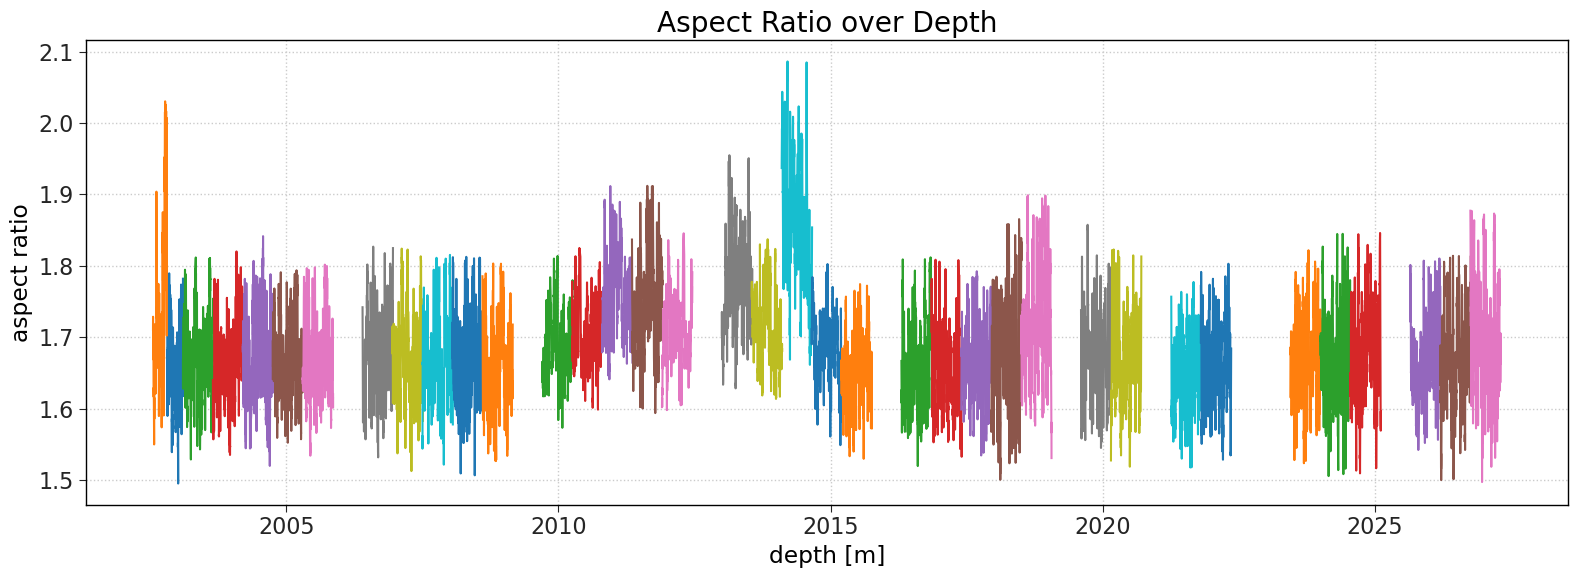

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Function to read and add aspect ratio to CSV files, with outlier removal
def read_and_add_aspect_ratio(path, bags):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )

        # Remove outliers using IQR method
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate aspect ratio
df_aspect_ratio = read_and_add_aspect_ratio(file_path, bag_list)

# Plot aspect ratio over depth
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.ticklabel_format(useOffset=False, style="plain")

# Iterate over each bag in the df_aspect_ratio dictionary and plot its aspect ratio over depth
for bag in list(df_aspect_ratio.keys()):
    ax.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["aspect_ratio"],
        "-",
        label=bag,
    )

ax.set(title="Aspect Ratio over Depth", xlabel="depth [m]", ylabel="aspect ratio")
# ax.legend()  # Show legend to identify bags

fig.tight_layout()
# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/aspect_ratio_over_depth.png", dpi=200)
plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

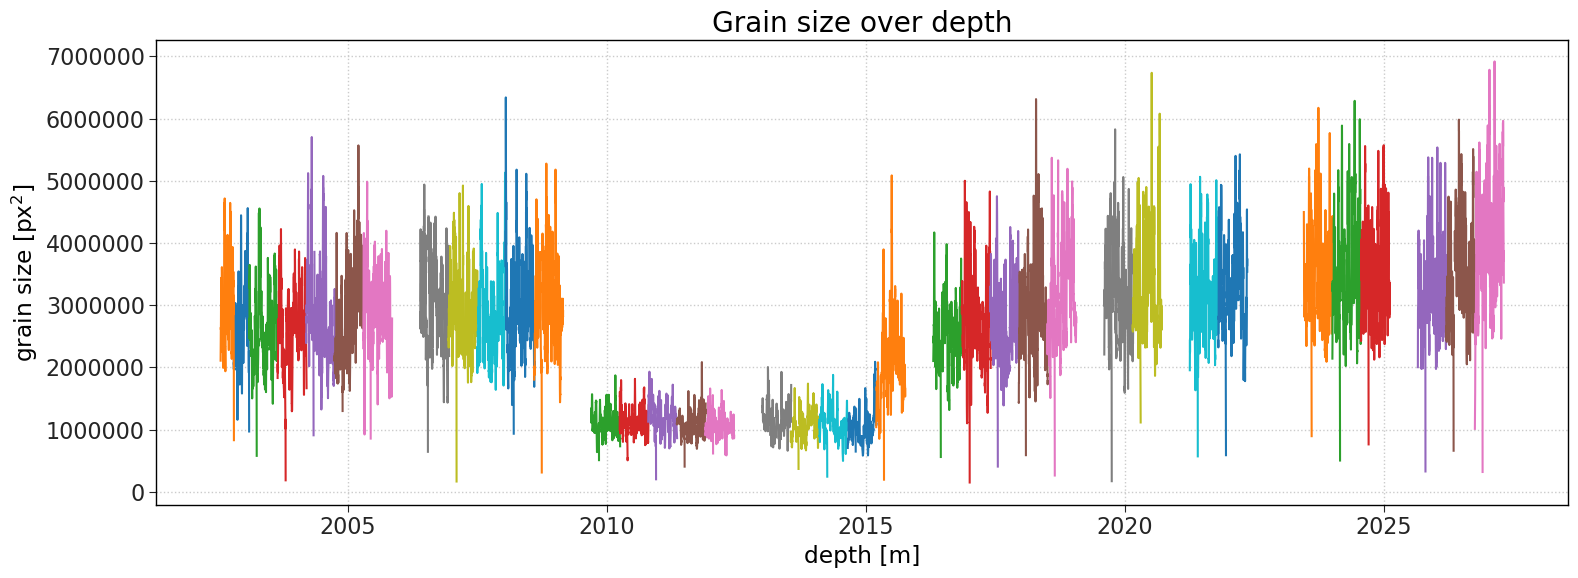

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.ticklabel_format(useOffset=False, style="plain")

# Iterate over each bag in the df_sizes dictionary and plot its grain size over depth
for bag in list(df_sizes.keys()):
    # Ensure depth is in meters and grain size in px^2 for consistent scaling and labeling
    ax.plot(df_sizes[bag]["depth[m]"], df_sizes[bag]["grain_size[px]"], "-", label=bag)

ax.set(title="Grain size over depth", xlabel="depth [m]", ylabel="grain size [px$^2$]")
# ax.legend()  # Show legend to identify bags

fig.tight_layout()
# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/6_grain_size_NEEM_bags.png", dpi=200)
plt.show()

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


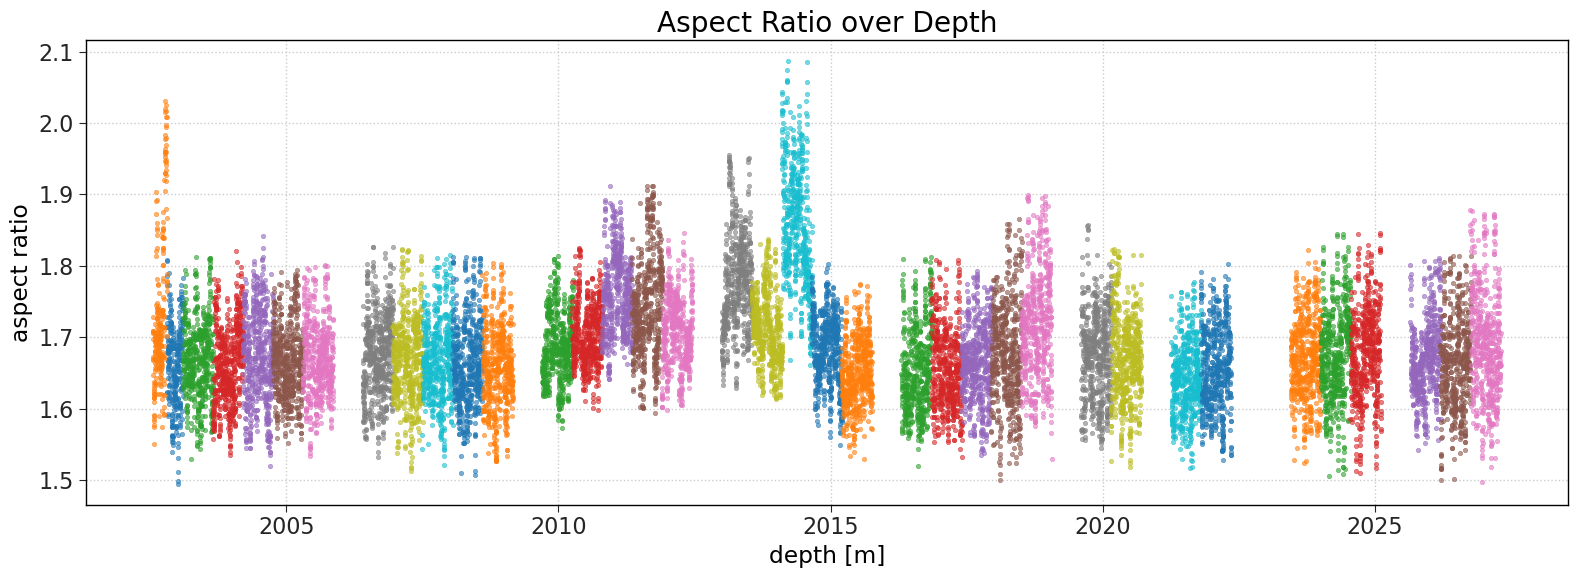

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Function to read and add aspect ratio to CSV files, with outlier removal
def read_and_add_aspect_ratio(path, bags):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )

        # Remove outliers using IQR method
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate aspect ratio
df_aspect_ratio = read_and_add_aspect_ratio(file_path, bag_list)

# Plot aspect ratio over depth
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.ticklabel_format(useOffset=False, style="plain")

# Iterate over each bag in the df_aspect_ratio dictionary and plot its aspect ratio over depth as scatter points
for bag in list(df_aspect_ratio.keys()):
    ax.scatter(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["aspect_ratio"],
        s=10,
        label=bag,
        alpha=0.6,
    )

ax.set(title="Aspect Ratio over Depth", xlabel="depth [m]", ylabel="aspect ratio")
# ax.legend()  # Show legend to identify bags

fig.tight_layout()
# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/aspect_ratio_over_depth-v2.png", dpi=200)
plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


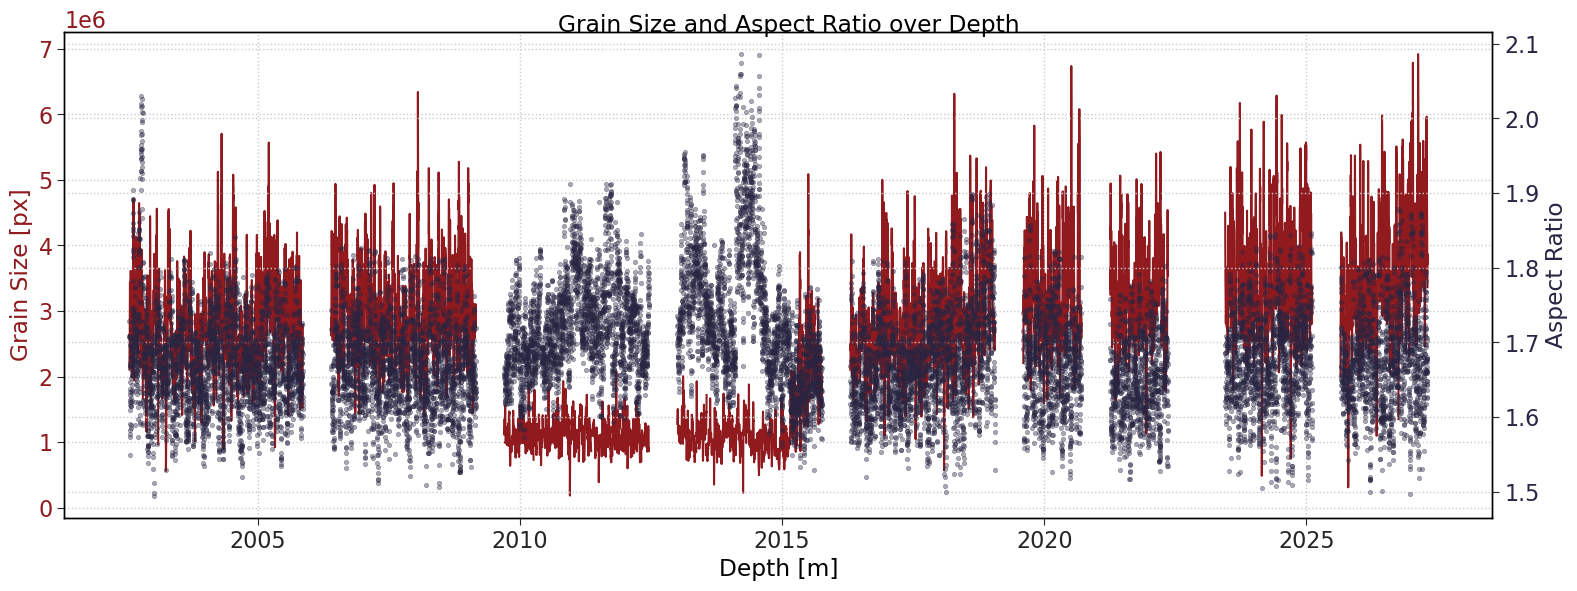

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Function to read and add aspect ratio to CSV files, with outlier removal
def read_and_add_aspect_ratio(path, bags):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )

        # Remove outliers using IQR method
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate aspect ratio
df_aspect_ratio = read_and_add_aspect_ratio(file_path, bag_list)

# Plot grain size and aspect ratio over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Grain size plot with a reddish color
for bag in list(df_aspect_ratio.keys()):
    ax1.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["grain_size[px]"],
        "-",
        color="#901A1E",
        alpha=1,
        label=f"{bag} Grain Size",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Grain Size [px]", color="#901A1E")
ax1.tick_params(axis="y", labelcolor="#901A1E")

# Create a secondary y-axis for the aspect ratio
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.scatter(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["aspect_ratio"],
        s=10,
        color="#292643",
        alpha=0.4,
        label=f"{bag} Aspect Ratio",
    )

ax2.set_ylabel("Aspect Ratio", color="#292643")
ax2.tick_params(axis="y", labelcolor="#292643")

# Title and layout
fig.suptitle("Grain Size and Aspect Ratio over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/grain_size_aspect_ratio_over_depth.png", dpi=200)

plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


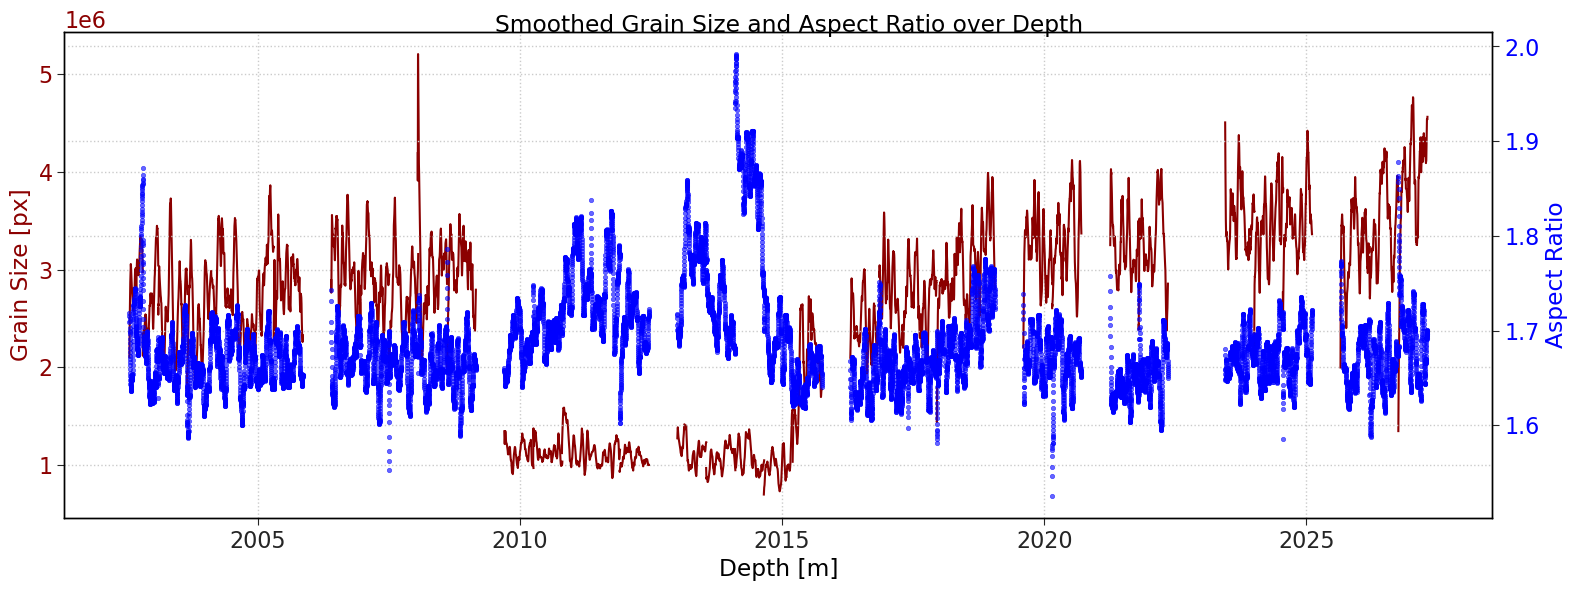

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Function to read, smooth, and add aspect ratio to CSV files, with outlier removal
def read_and_add_aspect_ratio(path, bags, window=50):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )

        # Remove outliers using IQR method
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        # Apply smoothing (moving average) to grain size and aspect ratio
        df_bag["smoothed_grain_size"] = (
            df_bag["grain_size[px]"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_aspect_ratio"] = (
            df_bag["aspect_ratio"].rolling(window=window, min_periods=1).mean()
        )

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate aspect ratio, applying smoothing
df_aspect_ratio = read_and_add_aspect_ratio(file_path, bag_list)

# Plot smoothed grain size and aspect ratio over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Grain size plot with a reddish color
for bag in list(df_aspect_ratio.keys()):
    ax1.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_grain_size"],
        "-",
        color="darkred",
        alpha=1,
        label=f"{bag} Grain Size",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Grain Size [px]", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

# Create a secondary y-axis for the aspect ratio
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.scatter(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_aspect_ratio"],
        s=10,
        color="blue",
        alpha=0.6,
        label=f"{bag} Aspect Ratio",
    )

ax2.set_ylabel("Aspect Ratio", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Title and layout
fig.suptitle("Smoothed Grain Size and Aspect Ratio over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/smoothed_grain_size_aspect_ratio_over_depth.png", dpi=200)

plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


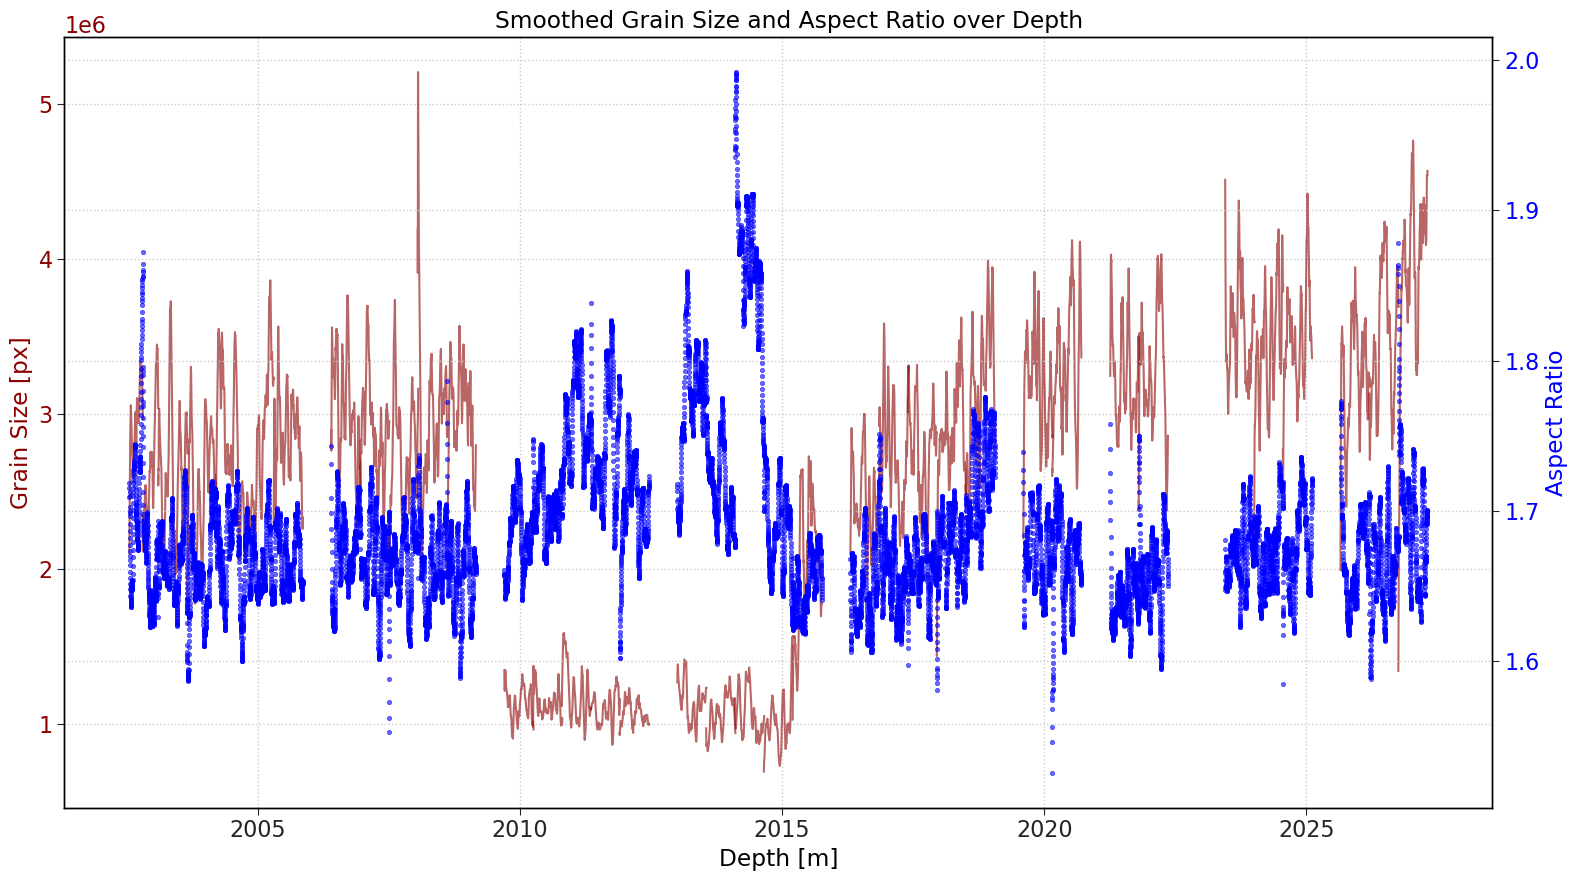

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Function to read, smooth, and add aspect ratio and orientation to CSV files, with outlier removal
def read_and_add_aspect_ratio_and_orientation(path, bags, window=50):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )

        # Remove outliers using IQR method
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        # Apply smoothing (moving average) to grain size, aspect ratio, and orientation
        df_bag["smoothed_grain_size"] = (
            df_bag["grain_size[px]"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_aspect_ratio"] = (
            df_bag["aspect_ratio"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_orientation"] = (
            df_bag["orientation"].rolling(window=window, min_periods=1).mean()
        )

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate aspect ratio and orientation, applying smoothing
df_aspect_ratio = read_and_add_aspect_ratio_and_orientation(file_path, bag_list)

# Plot smoothed grain size and aspect ratio over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))

# Grain size plot with a reddish color
for bag in list(df_aspect_ratio.keys()):
    ax1.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_grain_size"],
        "-",
        color="darkred",
        alpha=0.6,
        label=f"{bag} Grain Size",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Grain Size [px]", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

# Create a secondary y-axis for the aspect ratio
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.scatter(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_aspect_ratio"],
        s=10,
        color="blue",
        alpha=0.6,
        label=f"{bag} Aspect Ratio",
    )

ax2.set_ylabel("Aspect Ratio", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Title and layout
fig.suptitle("Smoothed Grain Size and Aspect Ratio over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
# fig.savefig("Plots/smoothed_grain_size_aspect_ratio_over_depth.png", dpi=100)

plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

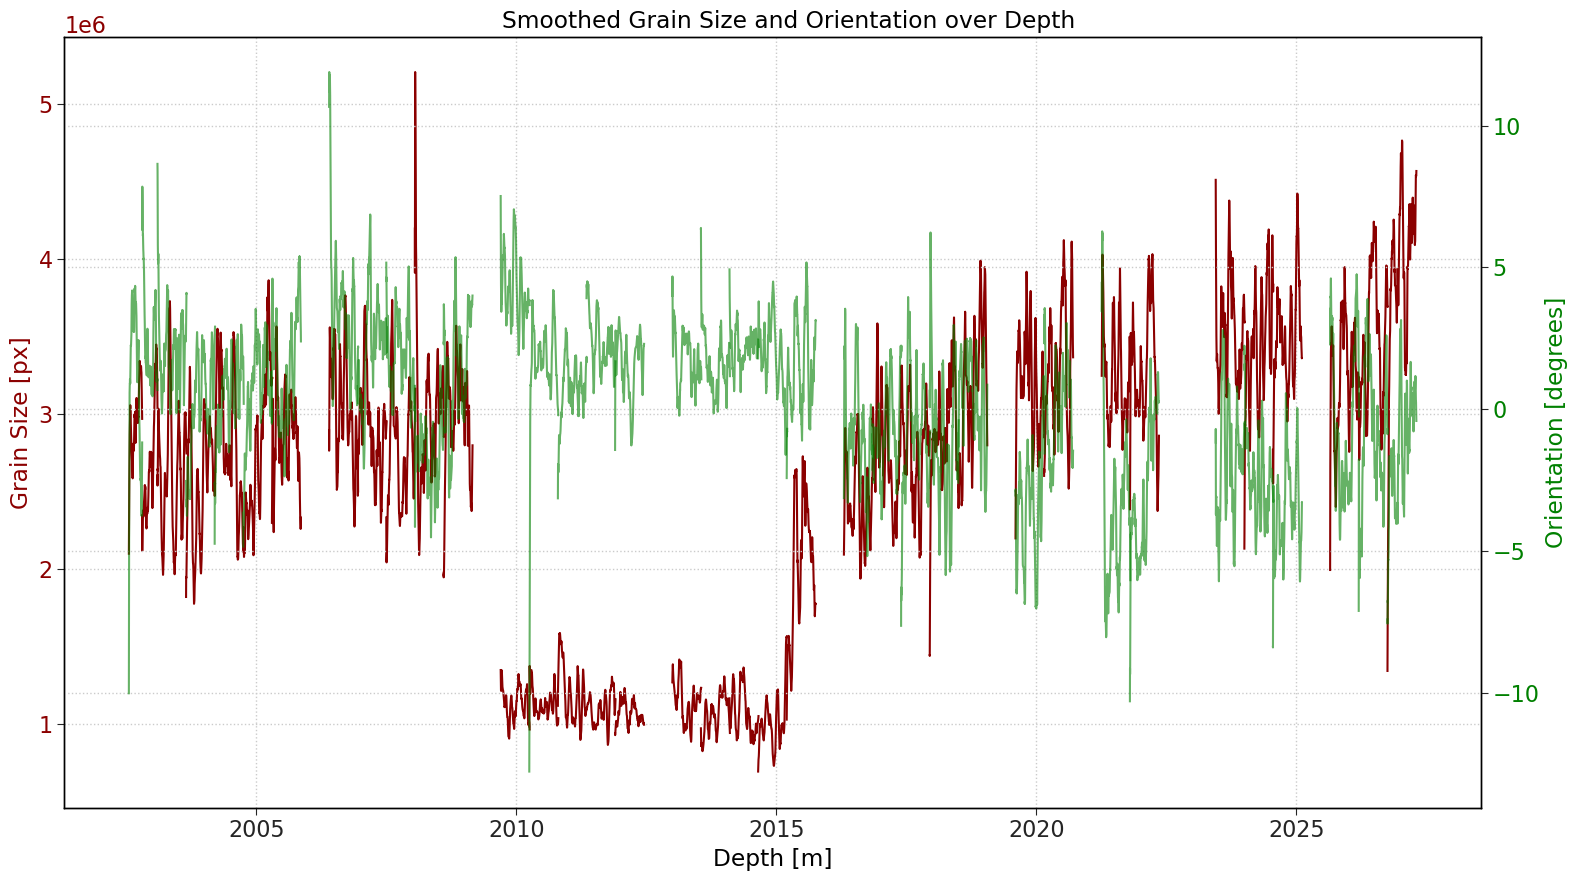

In [15]:
# Plot smoothed orientation and grain size over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))

# Grain size plot with a reddish color
for bag in list(df_aspect_ratio.keys()):
    ax1.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_grain_size"],
        "-",
        color="darkred",
        alpha=1,
        label=f"{bag} Grain Size",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Grain Size [px]", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

# Create a secondary y-axis for the orientation
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_orientation"],
        "-",
        color="green",
        alpha=0.6,
        label=f"{bag} Orientation",
    )

ax2.set_ylabel("Orientation [degrees]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Title and layout
fig.suptitle("Smoothed Grain Size and Orientation over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
# fig.savefig("Plots/smoothed_grain_size_orientation_over_depth.png", dpi=100)

plt.show()

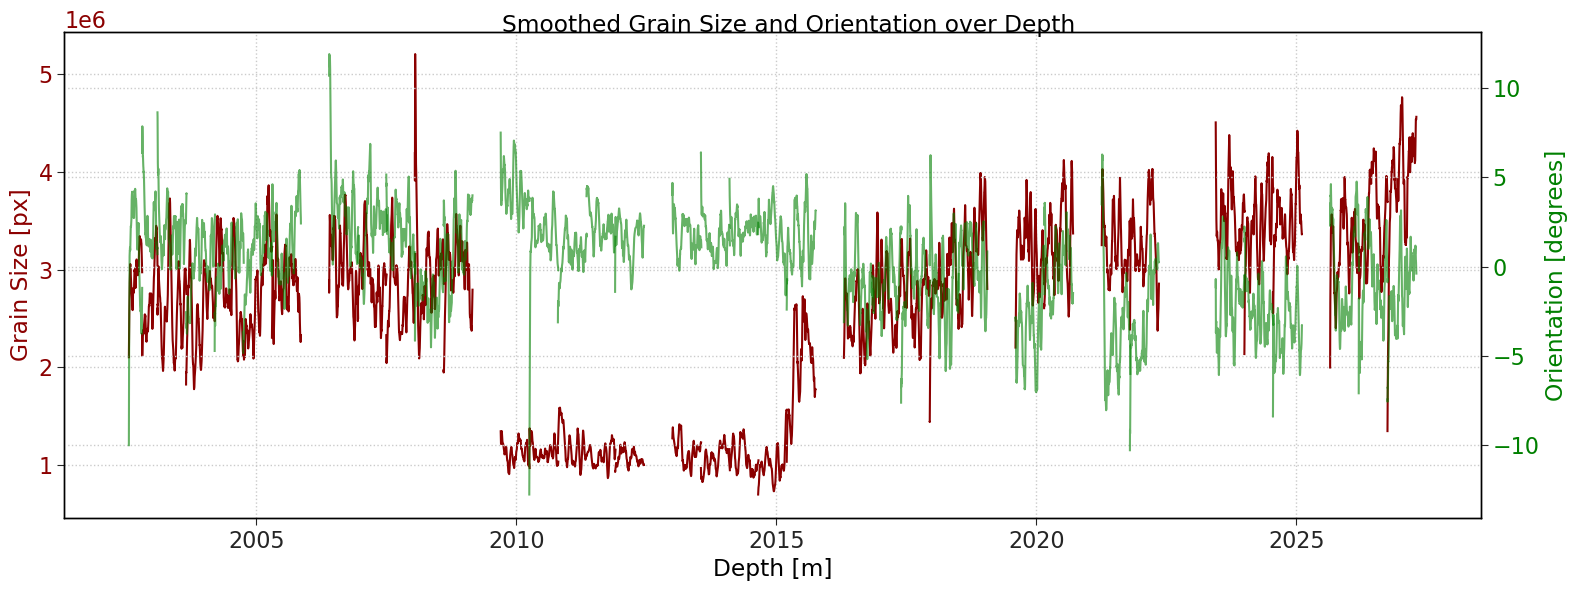

In [16]:
# Plot smoothed orientation and grain size over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Grain size plot with a reddish color
for bag in list(df_aspect_ratio.keys()):
    ax1.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_grain_size"],
        "-",
        color="darkred",
        alpha=1,
        label=f"{bag} Grain Size",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Grain Size [px]", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

# Create a secondary y-axis for the orientation
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_orientation"],
        "-",
        color="green",
        alpha=0.6,
        label=f"{bag} Orientation",
    )

ax2.set_ylabel("Orientation [degrees]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Title and layout
fig.suptitle("Smoothed Grain Size and Orientation over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/smoothed_grain_size_orientation_over_depth.png", dpi=200)

plt.show()

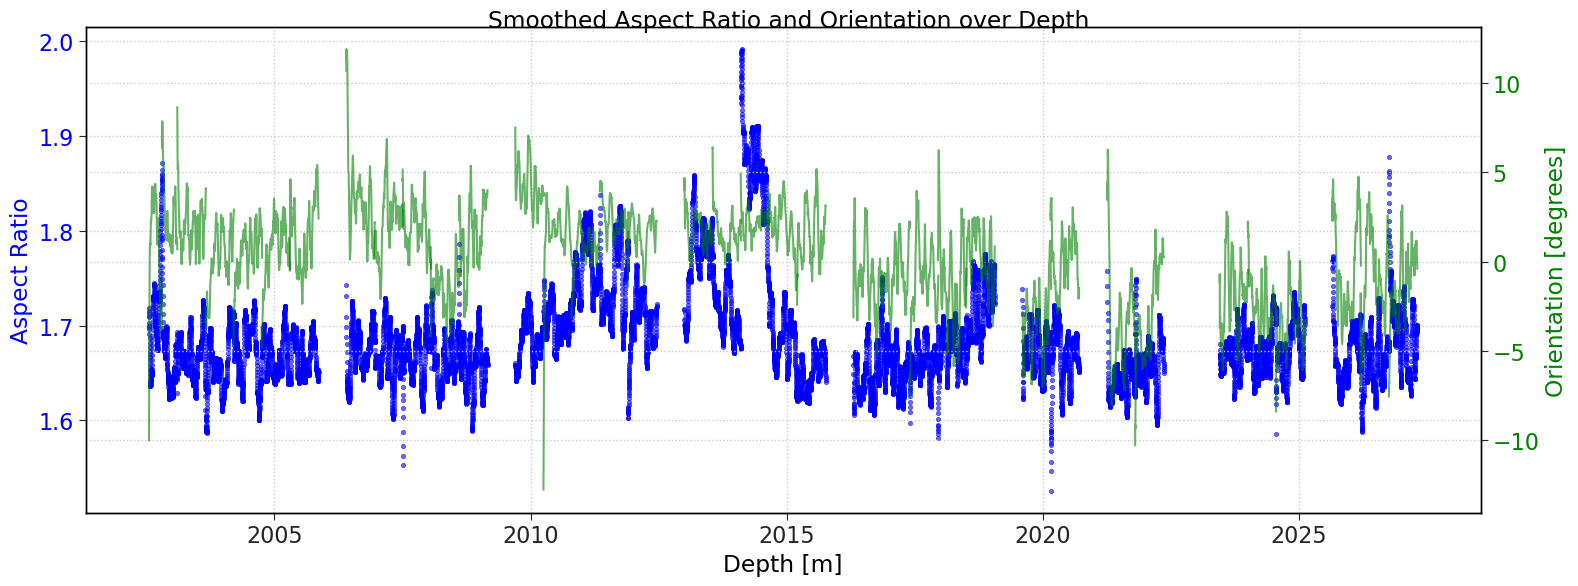

In [21]:
# Plot smoothed orientation and aspect ratio over depth
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Aspect ratio plot with a blue color
for bag in list(df_aspect_ratio.keys()):
    ax1.scatter(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_aspect_ratio"],
        s=10,
        color="blue",
        alpha=0.6,
        label=f"{bag} Aspect Ratio",
    )

ax1.set_xlabel("Depth [m]")
ax1.set_ylabel("Aspect Ratio", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for the orientation
ax2 = ax1.twinx()
for bag in list(df_aspect_ratio.keys()):
    ax2.plot(
        df_aspect_ratio[bag]["depth[m]"],
        df_aspect_ratio[bag]["smoothed_orientation"],
        "-",
        color="green",
        alpha=0.6,
        label=f"{bag} Orientation",
    )

ax2.set_ylabel("Orientation [degrees]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Title and layout
fig.suptitle("Smoothed Aspect Ratio and Orientation over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/smoothed_aspect_ratio_orientation_over_depth.png", dpi=200)

plt.show()

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


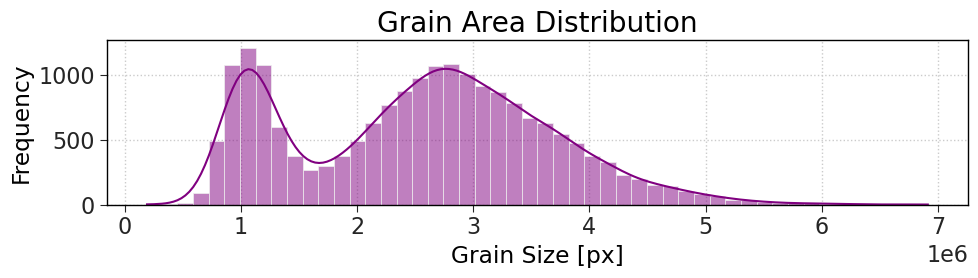

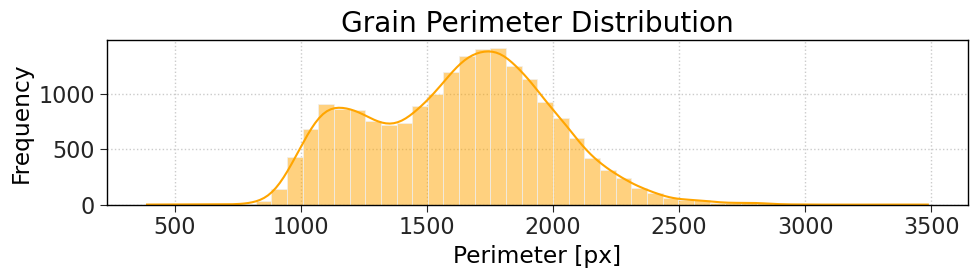

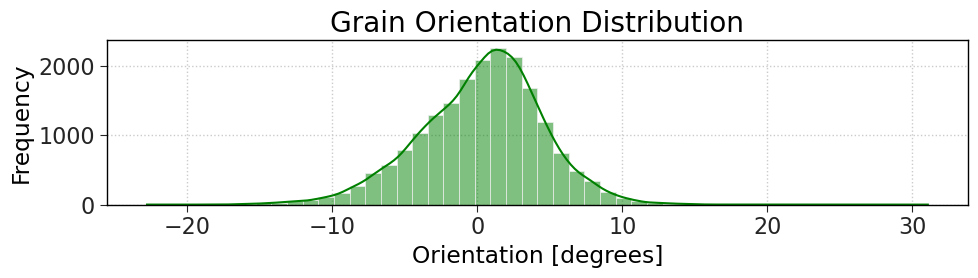

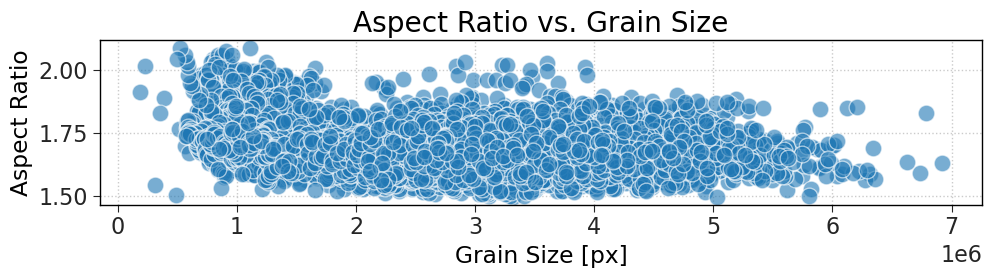

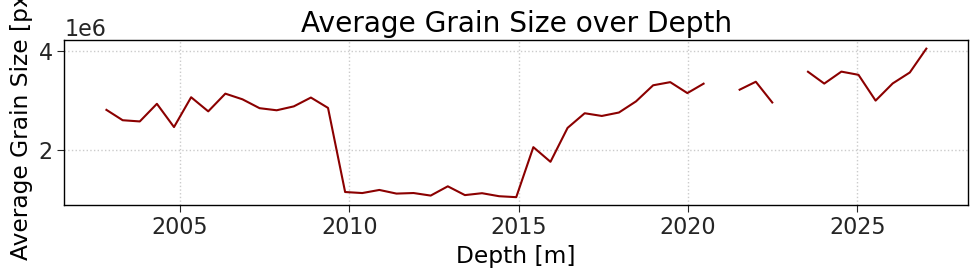

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


# Function to read, smooth, and add morphology metrics to CSV files, with outlier removal
def read_and_add_morphology_metrics(path, bags, window=50):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )
        # Calculate shape factor
        df_bag["shape_factor"] = (4 * np.pi * df_bag["grain_size[px]"]) / (
            df_bag["perimeter"] ** 2
        )
        # Calculate elongation
        df_bag["elongation"] = df_bag["major_axis_length"] / df_bag["minor_axis_length"]

        # Remove outliers using IQR method for aspect ratio
        Q1 = df_bag["aspect_ratio"].quantile(0.25)
        Q3 = df_bag["aspect_ratio"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_bag = df_bag[
            (df_bag["aspect_ratio"] >= lower_bound)
            & (df_bag["aspect_ratio"] <= upper_bound)
        ]

        # Apply smoothing (moving average) to grain size, aspect ratio, and orientation
        df_bag["smoothed_grain_size"] = (
            df_bag["grain_size[px]"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_aspect_ratio"] = (
            df_bag["aspect_ratio"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_orientation"] = (
            df_bag["orientation"].rolling(window=window, min_periods=1).mean()
        )

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files and calculate morphology metrics, applying smoothing
df_morphology = read_and_add_morphology_metrics(file_path, bag_list)

# Combine all data into a single DataFrame for analysis
combined_df = pd.concat(df_morphology.values(), ignore_index=True)

# 3. Grain Area Distribution
plt.figure(figsize=(10, 3))
sns.histplot(combined_df["grain_size[px]"], bins=50, kde=True, color="purple")
plt.title("Grain Area Distribution")
plt.xlabel("Grain Size [px]")
plt.ylabel("Frequency")
plt.tight_layout()
# Optional: Uncomment to save the figure
plt.savefig("Plots/draft/multi-grain_area_distribution.png", dpi=200)
plt.show()

# 4. Grain Perimeter Distribution
plt.figure(figsize=(10, 3))
sns.histplot(combined_df["perimeter"], bins=50, kde=True, color="orange")
plt.title("Grain Perimeter Distribution")
plt.xlabel("Perimeter [px]")
plt.ylabel("Frequency")
plt.tight_layout()
# Optional: Uncomment to save the figure
plt.savefig("Plots/draft/multi-grain_perimeter_distribution.png", dpi=200)
plt.show()

# 5. Grain Orientation Distribution
plt.figure(figsize=(10, 3))
sns.histplot(combined_df["orientation"], bins=50, kde=True, color="green")
plt.title("Grain Orientation Distribution")
plt.xlabel("Orientation [degrees]")
plt.ylabel("Frequency")
plt.tight_layout()
# Optional: Uncomment to save the figure
plt.savefig("Plots/draft/multi-grain_orientation_distribution.png", dpi=200)
plt.show()

# 6. Aspect Ratio vs. Grain Size
plt.figure(figsize=(10, 3))
sns.scatterplot(data=combined_df, x="grain_size[px]", y="aspect_ratio", alpha=0.6)
plt.title("Aspect Ratio vs. Grain Size")
plt.xlabel("Grain Size [px]")
plt.ylabel("Aspect Ratio")
plt.tight_layout()
# Optional: Uncomment to save the figure
plt.savefig("Plots/draft/multi-aspect_ratio_vs_grain_size.png", dpi=200)
plt.show()

# 7. Average Grain Size Over Depth
depth_intervals = np.linspace(
    combined_df["depth[m]"].min(), combined_df["depth[m]"].max(), num=50
)
combined_df["depth_bin"] = pd.cut(combined_df["depth[m]"], bins=depth_intervals)
avg_grain_size = combined_df.groupby("depth_bin")["grain_size[px]"].mean().reset_index()

plt.figure(figsize=(10, 3))
plt.plot(
    avg_grain_size["depth_bin"].apply(lambda x: x.mid),
    avg_grain_size["grain_size[px]"],
    color="darkred",
)
plt.title("Average Grain Size over Depth")
plt.xlabel("Depth [m]")
plt.ylabel("Average Grain Size [px]")
plt.tight_layout()
# Optional: Uncomment to save the figure
plt.savefig("Plots/draft/multi-average_grain_size_over_depth.png", dpi=200)
plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


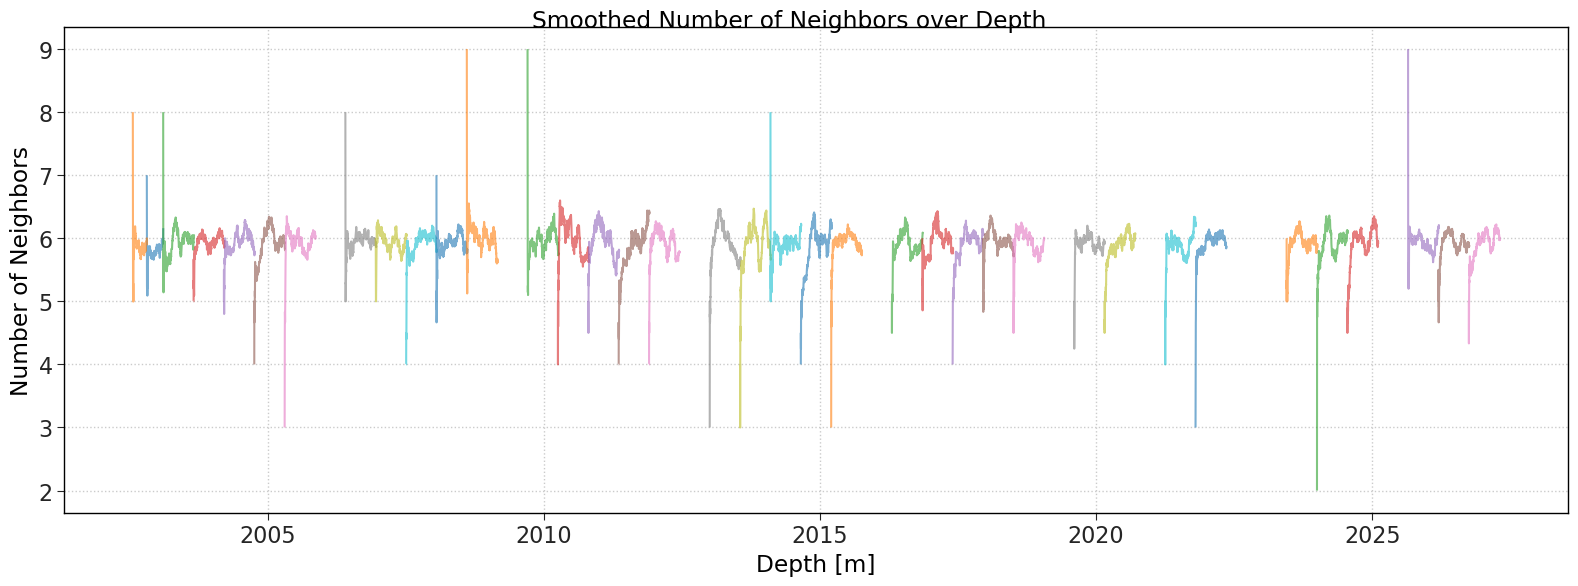

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import Delaunay


# Function to read, smooth, add morphology metrics, and compute neighbors for grains
def read_and_add_neighbors(path, bags, window=100):
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        bag_path = base_path / f"{bag}.csv"
        if not bag_path.exists():
            print(f"File not found: {bag_path}")
            continue
        df_bag = pd.read_csv(bag_path)
        # Calculate aspect ratio
        df_bag["aspect_ratio"] = (
            df_bag["major_axis_length"] / df_bag["minor_axis_length"]
        )
        # Calculate shape factor
        df_bag["shape_factor"] = (4 * np.pi * df_bag["grain_size[px]"]) / (
            df_bag["perimeter"] ** 2
        )
        # Calculate elongation
        df_bag["elongation"] = df_bag["major_axis_length"] / df_bag["minor_axis_length"]

        # Remove rows with NaN values in centroid coordinates
        df_bag = df_bag.dropna(subset=["centroid_x", "centroid_y"])

        # Delaunay triangulation to find neighbors
        points = df_bag[["centroid_x", "centroid_y"]].values
        tri = Delaunay(points)
        neighbors = {i: set() for i in range(len(points))}
        for simplex in tri.simplices:
            for i in range(3):
                for j in range(i + 1, 3):
                    neighbors[simplex[i]].add(simplex[j])
                    neighbors[simplex[j]].add(simplex[i])

        df_bag["num_neighbors"] = [len(neighbors[i]) for i in range(len(points))]

        # Apply smoothing (moving average) to grain size, aspect ratio, orientation, and number of neighbors
        df_bag["smoothed_grain_size"] = (
            df_bag["grain_size[px]"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_aspect_ratio"] = (
            df_bag["aspect_ratio"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_orientation"] = (
            df_bag["orientation"].rolling(window=window, min_periods=1).mean()
        )
        df_bag["smoothed_num_neighbors"] = (
            df_bag["num_neighbors"].rolling(window=window, min_periods=1).mean()
        )

        df[bag] = df_bag
    return df


# Path to the new CSV files
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/resolution_10mm-v2/"
with open(
    "/home/miguel/Documents/10_projects/reGrainable/data/bag-list-1.txt", "r"
) as file:
    bag_list = [line.strip() for line in file if line.strip()]

# Read the new CSV files, calculate neighbors, and apply smoothing
df_neighbors = read_and_add_neighbors(file_path, bag_list)

# Combine all data into a single DataFrame for analysis
combined_df = pd.concat(df_neighbors.values(), ignore_index=True)

# Plot smoothed number of neighbors over depth
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Number of neighbors plot
for bag in list(df_neighbors.keys()):
    ax.plot(
        df_neighbors[bag]["depth[m]"],
        df_neighbors[bag]["smoothed_num_neighbors"],
        "-",
        alpha=0.6,
        label=f"{bag} Number of Neighbors",
    )

ax.set_xlabel("Depth [m]")
ax.set_ylabel("Number of Neighbors")
ax.tick_params(axis="y")

# Title and layout
fig.suptitle("Smoothed Number of Neighbors over Depth")
fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle

# Optional: Uncomment to save the figure
fig.savefig("Plots/draft/smoothed_num_neighbors_over_depth.png", dpi=200)

plt.show()
# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)